# Spaceship Titanic 
## Use passenger data to predict who gets transported to an alternate dimension 

https://www.kaggle.com/competitions/spaceship-titanic

In [1]:
%cd ~/code/kaggle/spaceship-titanic 

/home/sammy/projects/data-science-sandbox/spaceship-titanic


In [2]:
# Import libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

## Load and explore data

In [3]:
# Load the train and test data 
data_path = 'data/'
train_data = pd.read_csv(data_path + 'train.csv')
test_data = pd.read_csv(data_path + 'test.csv')

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
# Remove passengers with unknown outcome 
X = train_data.dropna(axis=0, subset=['Transported']) 
y = X.Transported 

In [6]:
# Investigate data types and missing data
print('X dims: \t{}'.format(X.shape))  
print('y dim:  \t {}'.format(y.size))
print('True rate: \t{}%'.format(round(100*y.sum()/y.size, 2)))

X dims: 	(8693, 14)
y dim:  	 8693
True rate: 	50.36%


In [7]:
def col_info(df, cat_features=None): 
    """
    From input dataframe df, 
    returns dataframe with 
        rows:  features  
        cols:  data type, unique count, and NaN count.  
    """
    col_list = [('type', df.dtypes), 
                ('unique_count', df.nunique()), 
                ('NaN_count', df.isna().sum())] 
    return pd.DataFrame(dict(col_list)) 

col_info(X) 

,type,unique_count,NaN_count
PassengerId,object,8693,0
HomePlanet,object,3,201
CryoSleep,object,2,217
Cabin,object,6560,199
Destination,object,3,182
Age,float64,80,179
VIP,object,2,203
RoomService,float64,1273,181
FoodCourt,float64,1507,183
ShoppingMall,float64,1115,208


## Preprocess data

In [8]:
# Replace missing numerical values with median 
numerical_cols = X.select_dtypes(include=['float64']).columns 
for col in numerical_cols: 
    med = X[col].median() 
    X[col].fillna(med, inplace=True)

In [9]:
# Split feature 'Cabin' -> ['CabinDeck', 'CabinNum', 'CabinSide']
X[['CabinDeck', 'CabinNum', 'CabinSide']] = X['Cabin'].str.split('/', expand=True) 
X.drop('Cabin', axis=1, inplace=True)

In [10]:
# Convert ordinal feature values into integer values 
int_cols = ['CabinDeck', 'CabinSide'] 
for col in int_cols: 
    X[col], _ = pd.factorize(X[col], sort=True, na_sentinel=None) 

In [11]:
# Split categorical features into indicator features
cat_cols = ['HomePlanet', 'Destination'] 
X = pd.get_dummies(X, prefix=['Home', 'Dest'], columns=cat_cols) 

In [12]:
# Convert booleans 
bool_cols = ['CryoSleep', 'VIP']  
for col in bool_cols: 
    X[col] = X[col].astype(bool) 

In [13]:
# Select features and drop samples with missing values 
features = ['CryoSleep', 'VIP', 
       'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 
       'VRDeck', 'CabinDeck', 'CabinSide', 
       'Home_Earth', 'Home_Europa', 'Home_Mars', 
       'Dest_55 Cancri e', 'Dest_PSO J318.5-22', 'Dest_TRAPPIST-1e']
X = X[features + ['Transported']] 
X.dropna(axis=0, inplace=True) 
y = X['Transported']
X.drop(['Transported'], axis=1, inplace=True); 

In [14]:
col_info(X)

,type,unique_count,NaN_count
CryoSleep,bool,2,0
VIP,bool,2,0
Age,float64,80,0
RoomService,float64,1273,0
FoodCourt,float64,1507,0
ShoppingMall,float64,1115,0
Spa,float64,1327,0
VRDeck,float64,1306,0
CabinDeck,int64,9,0
CabinSide,int64,3,0


## Train and validate model

In [15]:
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

In [16]:
# Find best parameters 
from sklearn.model_selection import GridSearchCV 
# from sklearn.metrics import f1_score 

param_grid = {'max_depth': range(8, 12),
              'n_estimators': range(40, 60, 5)}

grid = GridSearchCV(RandomForestClassifier(), param_grid, 
                    scoring='f1', cv=3, verbose=1) 
grid.fit(train_X, train_y);  

best_params = grid.best_params_ 
print(best_params) 

Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'max_depth': 9, 'n_estimators': 40}


In [17]:
# Define a random forest classifier model and train 
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(train_X, train_y) 

# Use model to predict boolean 'Transported' 
rf_val_predictions = rf_model.predict(val_X)

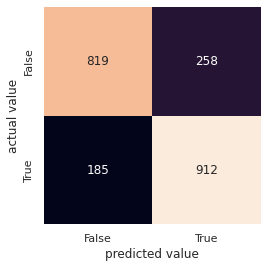

In [18]:
# Confusion matrix 
conf_mat = confusion_matrix(val_y, rf_val_predictions)

sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('predicted value')
plt.ylabel('actual value');  

In [19]:
# Classification report  
print(classification_report(val_y, rf_val_predictions)) 

              precision    recall  f1-score   support

       False       0.82      0.76      0.79      1077
        True       0.78      0.83      0.80      1097

    accuracy                           0.80      2174
   macro avg       0.80      0.80      0.80      2174
weighted avg       0.80      0.80      0.80      2174



## Retrain model on entire dataset 

In [20]:
# Create a new Random Forest Classifier model and fit model on all data 
rf_model_full = RandomForestClassifier(**best_params) 
rf_model_full.fit(X, y); 

# Load test data
test_data_path = 'data/'
test_X = pd.read_csv(data_path + 'test.csv')

# Replace missing numerical values with median 
numerical_cols = test_X.select_dtypes(include=['float64']).columns 
for col in numerical_cols: 
    med = test_X[col].median() 
    test_X[col].fillna(med, inplace=True)

test_X[['CabinDeck', 'CabinNum', 'CabinSide']] = test_X['Cabin'].str.split('/', expand=True) 
test_X.drop('Cabin', axis=1, inplace=True)

int_cols = ['CabinDeck', 'CabinSide'] 
for col in int_cols: 
    test_X[col], _ = pd.factorize(test_X[col], sort=True, na_sentinel=None) 

cat_cols = ['HomePlanet', 'Destination'] 
test_X = pd.get_dummies(test_X, prefix=['Home', 'Dest'], columns=cat_cols) 

bool_cols = ['CryoSleep', 'VIP']  
for col in bool_cols: 
    test_X[col] = test_X[col].astype(bool) 

IDs = test_X['PassengerId']
features = ['CryoSleep', 'VIP', 
       'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 
       'VRDeck', 'CabinDeck', 'CabinSide', 
       'Home_Earth', 'Home_Europa', 'Home_Mars', 
       'Dest_55 Cancri e', 'Dest_PSO J318.5-22', 'Dest_TRAPPIST-1e']
test_X = test_X[features] 

# Verify no missing data  
print(test_X.notna().all().all()) 

True


## Predict and export submission 

In [21]:
# Predict boolean 'Transported' 
test_pred = rf_model_full.predict(test_X) 

# Save predictions as CSV 
output = pd.DataFrame({'PassengerId': IDs, 
                       'Transported': test_pred})
output.to_csv(test_data_path + 'submission.csv', index=False)  